In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
import numpy as np
import torch.nn.functional as F
from math import exp
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import math
import time
import torch.nn.utils as utils

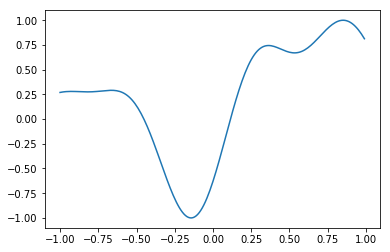

In [2]:
#############Load data########################
n=10000
xs = np.arange(-1.0, 1.0, 0.01)
func = torch.load('traindata_50000.pt')
func_t = torch.load('testdata_7000.pt')
plt.plot(xs,func_t[44])
plt.show()

In [3]:
############parameters################################
np.random.seed(77)
torch.manual_seed(77)
    
epoch=100
batch=50
    

step=20
future=0
hidden_size=64
learning_rate=1e-2
sigma=0.1

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array- value.data.numpy())).argmin()
    return idx

In [5]:
#input x and output y 
def query(action,func):
    y_out=[]
    x_out=[]
    for i in range(action.size(0)):
        idx=find_nearest(xs,action[i])
        y=func[i][idx]
        x_out.extend([xs[idx]])
        y_out.extend([y])
    x_out=np.array(x_out).reshape(action.size(0),1)
    x_out=torch.from_numpy(x_out[:])
    y_out=np.array(y_out).reshape(action.size(0),1)
    y_out=torch.from_numpy(y_out[:,:])
    input=torch.cat((x_out,y_out),1)
    return input,x_out,y_out

In [6]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(2,hidden_size)
        self.linear1= nn.Linear(hidden_size,1)
        self.tanh=nn.Tanh()
        
    def forward(self,input,func,future=0):
        outputs = []
        log_probs = []
        rewards = []
        entropies = []
        actions = []
        
        
        h_t = torch.zeros(input.size(0), hidden_size, requires_grad=False, dtype=torch.double).cuda()
        c_t = torch.zeros(input.size(0), hidden_size, requires_grad=False, dtype=torch.double).cuda()

        outputs += [input]
        
        for i in range(step+future):
            h_t, c_t = self.lstm1(input, (h_t, c_t))
            h_t=h_t.detach()
            c_t=c_t.detach()
            mean=self.linear1(h_t)
            mean=self.tanh(mean)
            # output mean
            
            m = torch.distributions.normal.Normal(mean,sigma)
            action=m.sample()
            entropy=m.entropy()
            
         
            #next input
            input,action_new,reward=query(action.cpu(),func)
            log_prob=m.log_prob(action_new.cuda())
         
            input=input.cuda()
            outputs += [input]
            
            log_probs.append(log_prob)
            rewards.append(reward)
            entropies.append(entropy)
            actions.append(action_new)
           
          
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs,log_probs,rewards,entropies,actions      

In [7]:
# min value at every step
def min_loss(rewards):
        min_step=[]    
        min_step_each=[] 
        min=rewards[0].clone()
        for i in range(len(rewards)):
            for j in range(rewards[i].size(0)):
                if rewards[i][j]<min[j]:
                    min[j]=rewards[i][j]
            min_step.append(min.mean())
            min_step_each.append(min.clone())   
        return min_step,min_step_each

In [8]:
#LOSS OI
def OI_loss(rewards):
    _,min_step= min_loss(rewards)
    R = torch.zeros(1, 1).double()
    R=rewards[0]*-1 
    for i in range(len(rewards)-1):
        for j in range(rewards[i].size(0)):
            if rewards[i+1][j]-min_step[i][j]<0:
                R[j] += (rewards[i+1][j]-min_step[i][j])*-1
            else :
                R[j] += 0.0 
    return R

In [9]:
#Loss OI
def reinforce_OI(log_probs,rewards,entropies):
    loss = 0
    R=OI_loss(rewards)
    for i in reversed(range(len(rewards))):
        loss = loss - (log_probs[i]*(Variable(R-R.mean()).expand_as(log_probs[i])).cuda()).sum()- (0.0001*entropies[i]).sum()
    loss = loss / len(rewards[0])/ len(rewards)
    return loss

In [10]:
#Loss SUM
def reinforce_sum(log_probs,rewards,entropies):
    R = torch.zeros(1, 1).double()
    loss = 0
    for i in range(len(rewards)):
        R = 0.9*R+ rewards[i]*-1
    for i in reversed(range(len(rewards))):
        loss = loss - (log_probs[i]*(Variable(R-R.mean()).expand_as(log_probs[i])).cuda()).sum()- (0.0001*entropies[i]).sum()
    loss = loss / len(rewards) / len(rewards[0])
    return loss

In [11]:
#Loss MIN
def reinforce_min(log_probs,rewards,entropies):
    R = torch.zeros(1, 1).double()
    loss = 0
    min_step=min_loss(rewards)
    R=min_step[-1]*-1
    for i in reversed(range(len(rewards))):     
        loss = loss - (log_probs[i]*(Variable(R-R.mean()).expand_as(log_probs[i])).cuda()).sum()- (0.0001*entropies[i]).sum()
    loss = loss / len(rewards) / len(rewards[0])
    return loss

In [12]:
if __name__ == '__main__':

    func=np.array(func)
    func_t=np.array(func_t)
    func_test = torch.from_numpy(func_t[0:2000, :])
    #starting point
    x0=torch.tensor([0.0]*func_test.size(0))
    input_test,_,_=query(x0,func_test)
    input_test=input_test.cuda()
    
    training_loss=[]
    testing_loss=[]
    
    # build the model
    seq = Sequence().cuda()
    seq.double()
    
    #load model
    #seq.load_state_dict(torch.load('seq40_190.pkl'))
    
    
    # use ADAM as optimizer 
    optimizer = optim.Adam(seq.parameters(), lr=learning_rate)
    #scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,0.95, last_epoch=-1)
    t0 = time.time()
    save_freq=10

    #begin to train
    for i in range(epoch):
        print('EPOCH: ', i)
        
        for j in range(int(n/batch)):
            func_train = torch.from_numpy(func[batch*j:batch*(j+1), :])
            x0=torch.tensor([0.0]*func_train.size(0))
            input,_,_=query(x0,func_train)
            input=input.cuda()
        
            optimizer.zero_grad()
            out,log_probs,rewards,entropies,actions = seq(input,func_train)
            loss=reinforce_sum(log_probs,rewards,entropies)
            training_loss.append(loss)
            loss.backward()
            utils.clip_grad_norm_(seq.parameters(), 6)
            optimizer.step()
            
            with torch.no_grad():
                out_test,log_probs,test_rewards,entropies,test_actions = seq(input_test,func_test,future)
                min_step,_=min_loss(test_rewards)
                print('test loss:', min_step[-1].item())
                testing_loss.append(min_step[-1].item())
                y = out_test.cpu().detach().numpy()
            
        print('time : {:.02e} seconds'.format(time.time() - t0))
    
    ########save model#######################
        #if (i+1) % save_freq == 0: 
        #    torch.save(seq.state_dict(), 'seq40_%d.pkl'%(i+1)) 
            
            

EPOCH:  0
test loss: -0.3682412053323177
test loss: -0.36087736618662847
test loss: -0.3628440634901577
test loss: -0.3659751837053042
test loss: -0.3696911060526679
test loss: -0.36840279071462095
test loss: -0.36842269296833313
test loss: -0.36944500542591807
test loss: -0.3706507718691691
test loss: -0.3712031110182948
test loss: -0.36664497211909675
test loss: -0.366077493296305
test loss: -0.37270224618216147
test loss: -0.37267069028955563
test loss: -0.3682065451706192
test loss: -0.37373540882881046
test loss: -0.3716359197387225
test loss: -0.3705475366808521
test loss: -0.3714296447205844
test loss: -0.3696780916276258
test loss: -0.3694419738400769
test loss: -0.37246668381147596
test loss: -0.3675507138693129
test loss: -0.3693139691651206
test loss: -0.36973478699739415
test loss: -0.3637540444108348
test loss: -0.3718724209487037
test loss: -0.3700402792462026
test loss: -0.3675122391068831
test loss: -0.3745406903101632
test loss: -0.3698195733441916
test loss: -0.371029

test loss: -0.42294853589097414
test loss: -0.4272456352315603
test loss: -0.432101293670396
test loss: -0.42345093070201734
test loss: -0.42208443362907466
test loss: -0.4253618019654891
test loss: -0.4256867679210222
test loss: -0.42240905378366733
test loss: -0.4198042801850406
test loss: -0.4247647072849739
test loss: -0.41931957387460966
test loss: -0.4214034316526392
test loss: -0.4278639506159712
test loss: -0.4248351946468967
test loss: -0.4240466556530468
test loss: -0.4221047798339341
test loss: -0.42353851463027314
test loss: -0.4248769504646897
test loss: -0.42785650448497387
test loss: -0.42466389594694726
test loss: -0.4197737969222877
test loss: -0.4273994155216839
test loss: -0.42601913926094276
test loss: -0.4250414753512421
test loss: -0.42442726376580714
test loss: -0.42728580878414385
test loss: -0.4271828148686042
test loss: -0.42668258817468063
test loss: -0.4249767499842419
test loss: -0.4248933671256287
test loss: -0.4228369212403837
test loss: -0.42345325932854

test loss: -0.4491827521237959
test loss: -0.4494229622779165
test loss: -0.4474885015010153
test loss: -0.44417760040418236
test loss: -0.4450377045880435
test loss: -0.4363730791814464
test loss: -0.4411901873143481
test loss: -0.44278192239774594
test loss: -0.4410128779729176
test loss: -0.44360130416459276
test loss: -0.4452117785427703
test loss: -0.4419648388997956
test loss: -0.44252481668083854
test loss: -0.44331368835699436
test loss: -0.441122701766401
test loss: -0.4417937240117342
test loss: -0.442752885646267
test loss: -0.4445571779467716
test loss: -0.44127573200835224
test loss: -0.44193762631600075
test loss: -0.4417029537919777
test loss: -0.4439242839803214
test loss: -0.4402712436169073
test loss: -0.4433866064111388
test loss: -0.43786514115275016
test loss: -0.4404025185764663
test loss: -0.4384314662048439
test loss: -0.43555334683517516
test loss: -0.4332607246132062
test loss: -0.43653834723352714
test loss: -0.43833006267728586
test loss: -0.4410476005350389

test loss: -0.33172412476829494
test loss: -0.3295089168725658
test loss: -0.3306109798725172
test loss: -0.32351877505707505
test loss: -0.3314595538577423
test loss: -0.33026877329901366
test loss: -0.32382183780314233
test loss: -0.32984833054284335
test loss: -0.32652918697288913
test loss: -0.32662737480028614
test loss: -0.3295175996074159
test loss: -0.32947101180770694
test loss: -0.33482885457872796
test loss: -0.3285973072270081
test loss: -0.32706924077031435
test loss: -0.3293522820399253
test loss: -0.3286494923661062
test loss: -0.33038438859702846
test loss: -0.32945972377383004
test loss: -0.3285533340411493
time : 7.96e+02 seconds
EPOCH:  4
test loss: -0.32832715502104776
test loss: -0.3302147011067833
test loss: -0.32828703457795655
test loss: -0.33427012126349614
test loss: -0.32949069018255345
test loss: -0.32539940387407745
test loss: -0.3270384667432225
test loss: -0.33057113332071103
test loss: -0.32916328385535903
test loss: -0.32108403974066985
test loss: -0.32

test loss: -0.34414985805579734
test loss: -0.3461017476940259
test loss: -0.34696891683472264
test loss: -0.3566559689642376
test loss: -0.3517046253973598
test loss: -0.3599239656720737
test loss: -0.3603234781006316
test loss: -0.3552839824962288
test loss: -0.3651989425736759
test loss: -0.3599021999772936
test loss: -0.36111472941474493
test loss: -0.35880537643171784
test loss: -0.3696033092554375
test loss: -0.3605289537938676
test loss: -0.35732078488218866
test loss: -0.3637540591046203
test loss: -0.36013793449838605
test loss: -0.3578152667693152
test loss: -0.3517100728757232
test loss: -0.35287357660740365
test loss: -0.358754000092054
test loss: -0.3529813989022995
test loss: -0.35316668128587864
test loss: -0.35030857965763207
test loss: -0.3603018341011953
test loss: -0.3586755296317775
test loss: -0.3635446038275032
test loss: -0.36010379835800466
test loss: -0.36106918735415094
test loss: -0.36403734881471045
test loss: -0.3576138344831436
test loss: -0.36189267940060

test loss: -0.5331922878772801
test loss: -0.5375243332169795
test loss: -0.5381687153529382
test loss: -0.5396566735778078
test loss: -0.5457118673316844
test loss: -0.5475597176738739
test loss: -0.5482147327226449
test loss: -0.549575413029222
test loss: -0.5495958124465925
test loss: -0.5507832529240198
test loss: -0.5519474957195214
test loss: -0.5511096758838835
test loss: -0.5502964179927097
test loss: -0.552091482612863
test loss: -0.5506574777461821
test loss: -0.5481666130066012
test loss: -0.554412995157915
test loss: -0.5479496087491682
test loss: -0.5408631399471677
test loss: -0.5446578232476041
test loss: -0.553455818226179
test loss: -0.5482853296360014
test loss: -0.5457833261332142
test loss: -0.5439226434553559
test loss: -0.5415811039489444
test loss: -0.5373222726246405
test loss: -0.5402151468163519
test loss: -0.5362994547631277
test loss: -0.5381861538983812
test loss: -0.5337067980399866
test loss: -0.5295852134109381
test loss: -0.5298136764610429
test loss: -

test loss: -0.5666971467959415
test loss: -0.5706997725622183
test loss: -0.5677576902559112
test loss: -0.575984860677301
test loss: -0.5718790441439107
test loss: -0.5789044392365643
test loss: -0.582858679505283
test loss: -0.581926451688344
test loss: -0.5782216958332919
test loss: -0.5768685913514218
test loss: -0.5829645483510794
test loss: -0.585257925895788
test loss: -0.5799573574702085
test loss: -0.5828991493724125
test loss: -0.5838860573549132
test loss: -0.580355737041581
test loss: -0.5835623027284428
test loss: -0.583987681136174
test loss: -0.5745474828623692
test loss: -0.581752044867877
test loss: -0.5801883515398812
test loss: -0.5823836075007516
test loss: -0.584036327577261
test loss: -0.5827694683622912
test loss: -0.5846404443530706
test loss: -0.5796416777780068
test loss: -0.5775967614095822
test loss: -0.5768412057174959
test loss: -0.5714313521781255
test loss: -0.5778926514771184
test loss: -0.5725094302343896
test loss: -0.5721453115360048
test loss: -0.57

test loss: -0.573971293568462
test loss: -0.5725611383695903
test loss: -0.5674263614342109
test loss: -0.5737282675435059
test loss: -0.5630633296048365
test loss: -0.5658384223660355
test loss: -0.5701115215747157
test loss: -0.5620598935210631
test loss: -0.5642966599552701
test loss: -0.5689363311559585
test loss: -0.5614927644921294
test loss: -0.5676692907278853
test loss: -0.5644186304480739
test loss: -0.5652070551539947
test loss: -0.5689919811073822
test loss: -0.5710952387390155
test loss: -0.5678011641392455
test loss: -0.5677674643471315
test loss: -0.571474637682687
test loss: -0.5650695222855744
test loss: -0.5673145868208789
test loss: -0.5640987911760175
test loss: -0.5659995995112436
test loss: -0.5626347452017643
test loss: -0.5593645502801997
test loss: -0.5626824484150895
test loss: -0.5633567212461734
test loss: -0.5649724555273581
test loss: -0.564937682907076
test loss: -0.5632280172459089
test loss: -0.5716857066372281
test loss: -0.5661278081652698
test loss: 

test loss: -0.5837679946693026
test loss: -0.5775683789602744
test loss: -0.579483095096778
test loss: -0.570287118244034
test loss: -0.5770005413666721
test loss: -0.58364698044579
test loss: -0.5847335902124461
test loss: -0.5815320801308141
test loss: -0.5841845610701057
test loss: -0.589723178499725
test loss: -0.5913394240728526
test loss: -0.5966595307682823
test loss: -0.5971173016154221
test loss: -0.5978123245889888
test loss: -0.5962544642648072
test loss: -0.5870435329543022
test loss: -0.586694796996981
test loss: -0.5915183583335974
test loss: -0.5918919236483063
test loss: -0.5946142127360142
test loss: -0.5896973897113928
test loss: -0.5873405055482713
test loss: -0.5945759414644023
test loss: -0.590591920997658
test loss: -0.5934184487546719
test loss: -0.5872128638746505
test loss: -0.5929175663912267
test loss: -0.5970411183667877
test loss: -0.5908686141463767
test loss: -0.599263540083338
test loss: -0.5895435729031693
test loss: -0.5920243466552153
test loss: -0.59

test loss: -0.6211291825219738
test loss: -0.6218112534209906
test loss: -0.6239770393335412
test loss: -0.6115691167953453
test loss: -0.616154253770728
test loss: -0.6193582463669807
test loss: -0.6151411901669662
test loss: -0.6186461594001396
test loss: -0.611566930676638
test loss: -0.6160799820707739
test loss: -0.611141950277086
test loss: -0.6092013167882689
test loss: -0.6103476907474511
test loss: -0.6068096199888838
test loss: -0.606030013459863
test loss: -0.6055377682236923
test loss: -0.6114129794355545
test loss: -0.61187030716221
test loss: -0.6126457805121049
test loss: -0.609795187564042
test loss: -0.6031109771540498
test loss: -0.6049127322783207
test loss: -0.6013379602531918
test loss: -0.6061442983320234
test loss: -0.6107818996935549
test loss: -0.6070683599308492
test loss: -0.6083099848427027
test loss: -0.6068555185691926
test loss: -0.6132983618724233
test loss: -0.6140347515755649
test loss: -0.6142760635244694
test loss: -0.6098669373295834
test loss: -0.6

test loss: -0.6450063260798491
test loss: -0.6391309475500664
test loss: -0.6410435007529708
test loss: -0.6462538804617127
test loss: -0.6457915608924383
test loss: -0.6414671393329197
test loss: -0.6408977215992517
test loss: -0.6457705632916506
test loss: -0.6390372812607865
test loss: -0.6340964681993022
test loss: -0.6383840721892222
test loss: -0.6444591582183778
test loss: -0.6317576952705793
test loss: -0.6342600018699319
test loss: -0.6346863299519785
test loss: -0.6320080566298786
test loss: -0.6355483321721432
test loss: -0.6333221394502085
test loss: -0.6295443303766993
test loss: -0.6290718891372556
test loss: -0.6292765007870827
test loss: -0.6321490354797612
test loss: -0.6323752431211934
test loss: -0.6298299812134992
test loss: -0.6325213161234235
test loss: -0.6330423872274697
test loss: -0.6312790682290494
test loss: -0.6370399297587342
test loss: -0.6341421978507449
test loss: -0.6397738457741821
test loss: -0.6376817259011694
test loss: -0.6427488784710352
test los

test loss: -0.638495316396436
test loss: -0.6369212043565629
test loss: -0.636879971417896
test loss: -0.6334317201240877
test loss: -0.634201229695834
test loss: -0.6443418367622519
test loss: -0.6434383112130123
test loss: -0.6447174520901473
test loss: -0.6461902739168346
test loss: -0.647081444012216
test loss: -0.6476831056738281
test loss: -0.6540760834575682
test loss: -0.6469206278108145
test loss: -0.6550517032412756
test loss: -0.6503523895040735
test loss: -0.6502308681703906
test loss: -0.6559898554804964
test loss: -0.6518745687691269
test loss: -0.6558951192016064
test loss: -0.6604627988966872
test loss: -0.6531713632889887
test loss: -0.6585819299062537
test loss: -0.6533363056287488
test loss: -0.6568935399718355
test loss: -0.6591359378315282
test loss: -0.658421086267108
test loss: -0.6601679593212534
test loss: -0.6616952728763488
test loss: -0.6611064098424597
test loss: -0.6557019383159195
test loss: -0.6549497771207514
test loss: -0.6558702903602521
test loss: -0

test loss: -0.6480660643820533
test loss: -0.6450708707363952
test loss: -0.6526660798233219
test loss: -0.6468476398375029
test loss: -0.6478259892994633
test loss: -0.6498589242288633
test loss: -0.6463078403480588
test loss: -0.6523747748110161
test loss: -0.6489955956464069
test loss: -0.6475394813319021
test loss: -0.6502968346252757
test loss: -0.6468992961074055
test loss: -0.6530005252678507
test loss: -0.6450406737430256
test loss: -0.6456853838537926
test loss: -0.6463249216125672
test loss: -0.6409204850966965
test loss: -0.6475290636235593
test loss: -0.6505279549517733
test loss: -0.6517967886485665
test loss: -0.6497507169681339
test loss: -0.65420616791006
test loss: -0.647995248710717
test loss: -0.6510889766261547
test loss: -0.6538455360432625
test loss: -0.6547450571957135
test loss: -0.6520226724655858
test loss: -0.6530280302567578
test loss: -0.6572955921974258
test loss: -0.6602016601894715
test loss: -0.6622891828647192
test loss: -0.6613814850347288
test loss: 

test loss: -0.7038980468965682
test loss: -0.6958255970664787
test loss: -0.6949795951029059
test loss: -0.7059329364480027
test loss: -0.7030448851306697
test loss: -0.7043517071434017
test loss: -0.7045059553147908
test loss: -0.7003353890047445
test loss: -0.7072989528984279
test loss: -0.7016782263499401
test loss: -0.7051293125965831
test loss: -0.7032596645517211
test loss: -0.6973709226715459
test loss: -0.7017916565730372
test loss: -0.7020032120029008
test loss: -0.7068336280779579
test loss: -0.7093125654971565
test loss: -0.7023353669662414
test loss: -0.7066006376709892
test loss: -0.7061282432724614
test loss: -0.7046627346898993
test loss: -0.7055582010932958
test loss: -0.7059586989797708
test loss: -0.703590987301515
test loss: -0.7088462404902162
test loss: -0.7105751650348948
test loss: -0.7029348609438897
test loss: -0.7053796810761147
test loss: -0.7062664711452205
test loss: -0.7083821878930555
test loss: -0.703293403559759
test loss: -0.7054590123101201
test loss:

test loss: -0.7267711138983475
test loss: -0.7189205699447149
test loss: -0.7228365912701837
test loss: -0.7254245136625972
test loss: -0.723684379411475
test loss: -0.7209103137638819
test loss: -0.7284701058598837
test loss: -0.7267911736497322
test loss: -0.7255914719741626
test loss: -0.7260647727344309
test loss: -0.7263940353496646
test loss: -0.7268946464198115
test loss: -0.7263107335803315
test loss: -0.7247789947046562
test loss: -0.7286705829288523
test loss: -0.7253923903462781
test loss: -0.7249214301007232
test loss: -0.7231895601326066
test loss: -0.7260764622743405
test loss: -0.7309403502740822
test loss: -0.7222438172091019
test loss: -0.7237010674381378
test loss: -0.7269131481032246
test loss: -0.7266304241772346
test loss: -0.7263765985027327
test loss: -0.7254846630102103
test loss: -0.7259301755116818
test loss: -0.7247122359962145
test loss: -0.7265551869327512
test loss: -0.7243413442323287
test loss: -0.7266863274146163
test loss: -0.7268249077427397
test loss

test loss: -0.7517019615200136
test loss: -0.7551126264824063
test loss: -0.753873787551651
test loss: -0.7499600509709456
test loss: -0.7453226377202071
test loss: -0.7480063589034941
test loss: -0.7470293715487881
test loss: -0.7483365800298198
test loss: -0.7474931823989291
test loss: -0.7515179068035152
test loss: -0.7454210794324282
test loss: -0.7475077589521008
test loss: -0.7488866800499844
test loss: -0.749466470099933
test loss: -0.7495420432851734
test loss: -0.746330912141085
test loss: -0.7468540000674143
test loss: -0.7482255528502472
test loss: -0.7483215421807354
test loss: -0.7479914383506943
test loss: -0.7424346046101477
test loss: -0.7438736946444878
test loss: -0.7384869610731594
test loss: -0.7402086385170096
test loss: -0.7420744556420621
test loss: -0.741475681861706
test loss: -0.7374003321851332
test loss: -0.7447543450422142
test loss: -0.742185182858187
test loss: -0.7468897836707163
test loss: -0.740147632568057
test loss: -0.7442570292093855
test loss: -0.

test loss: -0.7424109312891698
test loss: -0.7461914414910475
test loss: -0.7425441642719705
test loss: -0.7432156985778778
test loss: -0.7412811843674757
test loss: -0.740691681418841
test loss: -0.7442231292545659
test loss: -0.7443879232068972
test loss: -0.7426818627066463
test loss: -0.7469673913286584
test loss: -0.7443311002764852
test loss: -0.7509034257374547
test loss: -0.7493926873288196
test loss: -0.7477730113333171
test loss: -0.7454581893856282
test loss: -0.7512637284395365
test loss: -0.7552621189575502
test loss: -0.7537084712581086
test loss: -0.7556016494721589
test loss: -0.7537998078674595
test loss: -0.7551394764289137
test loss: -0.7550814747184557
test loss: -0.7532549982906381
test loss: -0.7576829640033442
test loss: -0.7563753230508719
test loss: -0.7551455855626488
test loss: -0.7531239517360718
test loss: -0.7577189595808789
test loss: -0.7543881504741294
test loss: -0.7583493335492117
test loss: -0.7606614608877809
test loss: -0.7582938102792363
test loss

test loss: -0.7714741195074066
test loss: -0.7756193582589294
test loss: -0.7722936634405465
test loss: -0.7684424838344804
test loss: -0.7756407033874846
test loss: -0.7707979359933966
test loss: -0.7713121059095145
test loss: -0.7740718608952553
test loss: -0.7839562511037306
test loss: -0.7759833802884446
test loss: -0.7770547223055566
test loss: -0.7663408878513444
test loss: -0.7761990244945566
test loss: -0.7732044062602956
test loss: -0.7779286644117009
test loss: -0.7783871950193971
test loss: -0.7779354959968008
test loss: -0.7787020299533145
test loss: -0.7739046167567109
test loss: -0.7779998809339954
test loss: -0.7713975694829539
test loss: -0.7730778448797997
test loss: -0.7769550615494377
test loss: -0.7785124259109025
test loss: -0.7744259350152651
test loss: -0.7728892850869984
test loss: -0.7745296268817262
test loss: -0.7739620987127608
test loss: -0.7727855165760831
test loss: -0.7738539052127018
test loss: -0.7646223044367519
test loss: -0.7657037654598178
test los

test loss: -0.8096594341795857
test loss: -0.8164992550070549
test loss: -0.8104033106830649
test loss: -0.8046306712328143
test loss: -0.8107151575587954
test loss: -0.8139087393809017
test loss: -0.8093489711558514
test loss: -0.811921075738746
test loss: -0.8134259996405853
test loss: -0.8093153896009698
test loss: -0.8080546954542543
test loss: -0.8114073316440474
test loss: -0.8100556852356134
test loss: -0.8104304744256666
test loss: -0.8139694640042597
test loss: -0.8134431515644697
test loss: -0.816199930571868
test loss: -0.8131009086400577
test loss: -0.8114336838171199
test loss: -0.8156036070335556
test loss: -0.8139081290384635
test loss: -0.8157167419574021
test loss: -0.8156401393391365
test loss: -0.8130976640427391
test loss: -0.8099538146769082
test loss: -0.8147849442302733
test loss: -0.8116075239310873
test loss: -0.8150290512765455
test loss: -0.8132350821284907
test loss: -0.8148826303863076
test loss: -0.8151152835502082
test loss: -0.8105678269513489
test loss:

test loss: -0.8167985372737708
test loss: -0.8189194232695786
test loss: -0.8202943137055672
test loss: -0.8232354180018691
test loss: -0.8215134252221701
test loss: -0.8194937049294517
test loss: -0.8217995793749625
test loss: -0.8171208052987523
test loss: -0.8225426063029171
test loss: -0.8202857705785891
test loss: -0.8246712082092172
test loss: -0.8244691529559691
test loss: -0.8209298519506638
test loss: -0.8226941370832702
test loss: -0.8266018958268241
test loss: -0.8274156951985083
test loss: -0.8299579136608307
test loss: -0.8256969028970412
test loss: -0.8347996915482562
test loss: -0.8267633602926098
test loss: -0.8273477227343253
test loss: -0.8275492528468774
test loss: -0.8192768697557254
test loss: -0.8270836089317688
test loss: -0.8213096263410101
test loss: -0.8319107231801149
test loss: -0.8299317441474645
test loss: -0.8281962307350746
test loss: -0.8352108318637845
test loss: -0.830436832590208
test loss: -0.8302049534122009
test loss: -0.8285446588053045
test loss

test loss: -0.8679359019838918
test loss: -0.8706711042814952
test loss: -0.8609568616207882
test loss: -0.8681439051496487
test loss: -0.8710178371932553
test loss: -0.8665188026770264
test loss: -0.8709857199271256
test loss: -0.8728025620915164
test loss: -0.8771646082457235
test loss: -0.8733823254812387
test loss: -0.8740029477546539
test loss: -0.879862542510674
test loss: -0.8755359701516516
test loss: -0.8733847999333014
test loss: -0.876083144945565
test loss: -0.8812135324047788
test loss: -0.8689343732937594
test loss: -0.8745330526690307
test loss: -0.8794443852359567
test loss: -0.8766953460837454
test loss: -0.8767774262414081
test loss: -0.8720635124452724
test loss: -0.8715558668800991
test loss: -0.8786214692642517
test loss: -0.8827959392484932
test loss: -0.8780013412053421
test loss: -0.8737870230723046
test loss: -0.8719578537587737
test loss: -0.8697471676540085
test loss: -0.8724309553675866
test loss: -0.8756661852508086
test loss: -0.8702210186868331
test loss:

test loss: -0.8389294202535752
test loss: -0.8379188774327035
test loss: -0.8407399260554798
test loss: -0.8437354785735839
test loss: -0.8427761338667515
test loss: -0.8392014420157811
test loss: -0.8437627340492734
test loss: -0.8448086486083832
test loss: -0.8450454285098993
test loss: -0.8486360722382029
test loss: -0.8477027348302646
test loss: -0.8494498899326709
test loss: -0.8515055269203539
test loss: -0.8499011443873615
test loss: -0.8544066267124524
test loss: -0.8560623825658172
test loss: -0.8520412440930243
test loss: -0.85624220074643
test loss: -0.8539906334269942
test loss: -0.8558955558609236
test loss: -0.855457389116334
test loss: -0.8531921216194942
test loss: -0.8547281799898029
test loss: -0.8613369286687798
test loss: -0.8553092113132549
test loss: -0.8550353313957249
test loss: -0.8548198255983824
test loss: -0.8518324942346057
test loss: -0.8602419110674956
test loss: -0.8559741138084838
test loss: -0.8568238463238417
test loss: -0.8547494245785976
test loss: 

test loss: -0.8840228284282066
test loss: -0.8848826713697625
test loss: -0.8883386765843293
test loss: -0.8825836269666182
test loss: -0.888252576041054
time : 4.79e+03 seconds
EPOCH:  29
test loss: -0.8842680035552254
test loss: -0.8872546556635877
test loss: -0.8929323862221109
test loss: -0.8893369111003575
test loss: -0.8913082272255028
test loss: -0.8943801065416235
test loss: -0.889213405033656
test loss: -0.89322134996609
test loss: -0.8896397521673343
test loss: -0.8879878072086238
test loss: -0.8932503575713967
test loss: -0.8890725706559197
test loss: -0.888604822116238
test loss: -0.8994901989599723
test loss: -0.8918271651878276
test loss: -0.8919435584330637
test loss: -0.8997492894738841
test loss: -0.8939185577876657
test loss: -0.8961638119915047
test loss: -0.8996823320453048
test loss: -0.8921288998818092
test loss: -0.8927913028237944
test loss: -0.8971862213683947
test loss: -0.8930419171584223
test loss: -0.8885944723505732
test loss: -0.8881611750631104
test loss

test loss: -0.9178489894905899
test loss: -0.9162982658630928
test loss: -0.9148253155632114
test loss: -0.9186506620628851
test loss: -0.9117057856351578
test loss: -0.9154748629897926
test loss: -0.9149946212174984
test loss: -0.9112772340096315
test loss: -0.9155428920222314
test loss: -0.9117250543871278
test loss: -0.9143025493102362
test loss: -0.9172104075518982
test loss: -0.9135294032609481
test loss: -0.9097186585868067
test loss: -0.9152008854620356
test loss: -0.91309995458922
test loss: -0.9147541258972981
test loss: -0.915403393132029
test loss: -0.9151523838159449
test loss: -0.9147644219869401
test loss: -0.9167283722817964
test loss: -0.9163724560309373
test loss: -0.9212241078598872
test loss: -0.9212592448546368
test loss: -0.920711930085169
test loss: -0.9140564692019135
test loss: -0.920792798101574
test loss: -0.9193916907802591
test loss: -0.9151541546755749
test loss: -0.9195165605950573
test loss: -0.9191137229261155
test loss: -0.9207264071081058
test loss: -0

test loss: -0.9172940119675088
test loss: -0.9186687744351619
test loss: -0.9161033574103732
test loss: -0.9216835444132888
test loss: -0.9160049699103899
test loss: -0.9198534997496561
test loss: -0.923685967133884
test loss: -0.9223744529645574
test loss: -0.9174040099656139
test loss: -0.9209400748311252
test loss: -0.9182895429378453
test loss: -0.9136720843161598
test loss: -0.9237598466977949
test loss: -0.9179059884124193
test loss: -0.9166093358157497
test loss: -0.9196579692220724
test loss: -0.9191746131936332
test loss: -0.9167304410801402
test loss: -0.9213914549779642
test loss: -0.9238456701983987
test loss: -0.9211613926527281
test loss: -0.9243577920492574
test loss: -0.9159754753564209
test loss: -0.9199929291976273
test loss: -0.9230297178539482
test loss: -0.9192559093226825
test loss: -0.9208456756641797
test loss: -0.9167970295564206
test loss: -0.9186356682769062
test loss: -0.9203712756635223
test loss: -0.9188158162362053
test loss: -0.916340371947963
test loss:

test loss: -0.9420166574766266
test loss: -0.9386592455735503
test loss: -0.9354688509460564
test loss: -0.9335948295011034
test loss: -0.9295114928840839
test loss: -0.9318803140726463
test loss: -0.9288922491829493
test loss: -0.9267740297539443
test loss: -0.9253077083099703
test loss: -0.929267905801676
test loss: -0.9287313900828865
time : 5.43e+03 seconds
EPOCH:  33
test loss: -0.9290486193816594
test loss: -0.9335405168280159
test loss: -0.9358464681830525
test loss: -0.9401378491482434
test loss: -0.9386875172685745
test loss: -0.9439934495885661
test loss: -0.9439209074430676
test loss: -0.9419988869725212
test loss: -0.9432932722242447
test loss: -0.9449591814638796
test loss: -0.9397835074888469
test loss: -0.9423004747921164
test loss: -0.9372744715911066
test loss: -0.9359777999090941
test loss: -0.9363798088897383
test loss: -0.9368911338148165
test loss: -0.9373453725726801
test loss: -0.9427520303451759
test loss: -0.9423185108753354
test loss: -0.9432987378082789
test 

test loss: -0.9365134184825304
test loss: -0.934682322841938
test loss: -0.9350948335287863
test loss: -0.9357244446399693
test loss: -0.9317200188810487
test loss: -0.9343725794696219
test loss: -0.9320714583224459
test loss: -0.936054147451857
test loss: -0.9380324342807478
test loss: -0.9375821287592961
test loss: -0.9394971977432798
test loss: -0.9385920696784618
test loss: -0.9362648649007143
test loss: -0.9319962534692032
test loss: -0.9310445813421355
test loss: -0.9339941308045311
test loss: -0.9289216454244389
test loss: -0.9295499591194089
test loss: -0.930483664741324
test loss: -0.92604994632559
test loss: -0.9325850899071896
test loss: -0.9315040050174177
test loss: -0.9284972333833575
test loss: -0.9275856900191496
test loss: -0.9278819113104061
test loss: -0.9308232638713334
test loss: -0.9287183423332137
test loss: -0.9296277150048022
test loss: -0.9249998944303673
test loss: -0.9316319365939145
test loss: -0.9280595414573761
test loss: -0.9328421673669466
test loss: -0

test loss: -0.9293323760143525
test loss: -0.928069208294754
test loss: -0.9287889921783197
test loss: -0.9343952394656136
test loss: -0.9326862788685852
test loss: -0.9326881972747121
test loss: -0.9350032244205054
test loss: -0.9366806125310725
test loss: -0.942704753173585
test loss: -0.9427093893217798
test loss: -0.9403567815521333
test loss: -0.9358091348358982
test loss: -0.9411873032962697
test loss: -0.9417466211441319
test loss: -0.9397440774527329
test loss: -0.942667950040507
test loss: -0.9381407112721617
test loss: -0.9459269858465837
test loss: -0.9466843088917235
test loss: -0.945467596055734
test loss: -0.9473120735525516
test loss: -0.9434082364486253
test loss: -0.9434210830148219
test loss: -0.9419140833377818
test loss: -0.9440013430853234
test loss: -0.9420374843350879
test loss: -0.9417613028129114
test loss: -0.9469477549845139
test loss: -0.9438466646313693
test loss: -0.9412267262282883
test loss: -0.9413370592588496
test loss: -0.9410281419775163
test loss: -

test loss: -0.9211770616936293
test loss: -0.9228251750147272
test loss: -0.9213388613768942
test loss: -0.9254647252616667
test loss: -0.9189132934881872
test loss: -0.9216429623099788
test loss: -0.9248026504198809
test loss: -0.9230955496995058
test loss: -0.9303649746313735
test loss: -0.9312236988204624
test loss: -0.9308552616802085
test loss: -0.9346926774452972
test loss: -0.9363246162590635
test loss: -0.933661655047135
test loss: -0.9374797561035997
test loss: -0.9377430816309361
test loss: -0.9357107242300418
test loss: -0.9384276446977589
time : 6.08e+03 seconds
EPOCH:  37
test loss: -0.932981727663359
test loss: -0.9350221369165709
test loss: -0.9332359380424899
test loss: -0.9377445360039817
test loss: -0.9391997657797516
test loss: -0.9357971964790347
test loss: -0.9409134053346402
test loss: -0.9376612031336414
test loss: -0.9408080510287216
test loss: -0.9389418291864325
test loss: -0.9385835900719772
test loss: -0.9387396293790709
test loss: -0.939187215713616
test lo

test loss: -0.9286766482760074
test loss: -0.927261616742613
test loss: -0.92400474111374
test loss: -0.9245767260024369
test loss: -0.9236811200476986
test loss: -0.922719512877372
test loss: -0.923486006801224
test loss: -0.9281120182909037
test loss: -0.9262135463829271
test loss: -0.9334472903094649
test loss: -0.9232202142441703
test loss: -0.9237841517360085
test loss: -0.9235397284203131
test loss: -0.9193684825559617
test loss: -0.9258383143410068
test loss: -0.9270922651703313
test loss: -0.9219200703990637
test loss: -0.9247988487014144
test loss: -0.9270158479352649
test loss: -0.9255958203658234
test loss: -0.9263835054323875
test loss: -0.9213794056205769
test loss: -0.9209480237676234
test loss: -0.9225117964928438
test loss: -0.9264255495364129
test loss: -0.9223039786530237
test loss: -0.9227599745906365
test loss: -0.9266151700414721
test loss: -0.9275516513768671
test loss: -0.9289387470621431
test loss: -0.9226330414781551
test loss: -0.9285063222085204
test loss: -0

test loss: -0.9191021190757536
test loss: -0.9202275186222824
test loss: -0.9201682468984594
test loss: -0.9222320542633875
test loss: -0.9228554340974835
test loss: -0.9128728068633801
test loss: -0.9186893220659974
test loss: -0.9221379548548629
test loss: -0.9186192053531579
test loss: -0.9202284627771258
test loss: -0.9190880050033172
test loss: -0.9189006069794506
test loss: -0.9171823861121897
test loss: -0.9181052574652758
test loss: -0.9216656281943147
test loss: -0.918994126380654
test loss: -0.9217620598064953
test loss: -0.9200864088819994
test loss: -0.921283975578339
test loss: -0.9193036943578309
test loss: -0.921315447156645
test loss: -0.9236676414933539
test loss: -0.9218573617950533
test loss: -0.9219133120766458
test loss: -0.9178100771063956
test loss: -0.9172283878920827
test loss: -0.9193876380269345
test loss: -0.9117582468871228
test loss: -0.9084226026253895
test loss: -0.9076367061446157
test loss: -0.9048670705485911
test loss: -0.8992150250068456
test loss: 

test loss: -0.9314175800874614
test loss: -0.9303253322383579
test loss: -0.9319324385213353
test loss: -0.9303279455085901
test loss: -0.9301065371336831
test loss: -0.93240939991238
test loss: -0.9262420978202631
test loss: -0.930972055851953
test loss: -0.9295513912197861
test loss: -0.9307752267901602
test loss: -0.9325736494784574
test loss: -0.9279779009590072
test loss: -0.9282461388724864
test loss: -0.9299875288840425
test loss: -0.9294342999788537
test loss: -0.9316282438201333
test loss: -0.929659471801787
test loss: -0.9305575540091112
test loss: -0.9245782753284524
test loss: -0.9264457868498615
test loss: -0.9321258535962734
test loss: -0.9305071642537752
test loss: -0.9279117909014863
test loss: -0.928859557230126
test loss: -0.9281770169904487
test loss: -0.9294331648766859
time : 6.75e+03 seconds
EPOCH:  41
test loss: -0.9314197417757478
test loss: -0.9338960694332782
test loss: -0.9327940025862964
test loss: -0.9324467737493191
test loss: -0.9290044805733673
test loss

test loss: -0.9381979584470234
test loss: -0.9428984708058004
test loss: -0.9345734287895607
test loss: -0.9418871647781928
test loss: -0.9383089471888064
test loss: -0.9394515998687698
test loss: -0.9395047186541156
test loss: -0.9442600655234151
test loss: -0.9411446000364739
test loss: -0.9413515783241823
test loss: -0.9406363603273327
test loss: -0.9361333133311359
test loss: -0.9379131763526649
test loss: -0.9342615429266588
test loss: -0.9383572787023435
test loss: -0.9328566700929749
test loss: -0.9401463135066381
test loss: -0.9346067212766739
test loss: -0.9359221343687077
test loss: -0.9363308707614092
test loss: -0.9341165280099989
test loss: -0.9391846102602485
test loss: -0.9381310176140176
test loss: -0.9361098980030191
test loss: -0.9402475537733186
test loss: -0.9343779107084367
test loss: -0.9435692972877959
test loss: -0.9414793762482231
test loss: -0.9427709655156689
test loss: -0.9451762888983536
test loss: -0.9374379782825638
test loss: -0.9411880264647444
test los

test loss: -0.9363144945948992
test loss: -0.9362717079802741
test loss: -0.9440133172762117
test loss: -0.9366479108710617
test loss: -0.9353078870752946
test loss: -0.9415892033911287
test loss: -0.9383117258516446
test loss: -0.938069293426551
test loss: -0.9390416718946331
test loss: -0.9414305952364125
test loss: -0.9407569926331415
test loss: -0.939876779155105
test loss: -0.9421138314928248
test loss: -0.943044924333997
test loss: -0.9411321709207485
test loss: -0.9422938707880348
test loss: -0.9436553434761029
test loss: -0.9431919550889308
test loss: -0.9400090219567275
test loss: -0.9394640975925339
test loss: -0.9418801409570678
test loss: -0.9348292577987827
test loss: -0.9387712215504805
test loss: -0.9350626740900349
test loss: -0.9368198291104626
test loss: -0.9368270250030089
test loss: -0.9381364425055562
test loss: -0.935301870627575
test loss: -0.9311505474747817
test loss: -0.9351577632879317
test loss: -0.9395785717263361
test loss: -0.9365933151258586
test loss: -

test loss: -0.914044753637524
test loss: -0.9130150369046168
test loss: -0.9089525576518371
test loss: -0.915242003867155
test loss: -0.9112971484091024
test loss: -0.9132695245340212
test loss: -0.91407244408109
test loss: -0.9119470813195492
test loss: -0.9164348907212544
test loss: -0.9137510793762645
test loss: -0.9061808285564531
test loss: -0.9052915005270926
test loss: -0.9028605970233792
test loss: -0.9071574307381132
test loss: -0.9067124358380473
test loss: -0.9054573338215792
test loss: -0.906094548034272
test loss: -0.9040109910847133
test loss: -0.9068904774100075
test loss: -0.9072889225517072
test loss: -0.9061921230979352
test loss: -0.9066478567283334
test loss: -0.916629434609767
test loss: -0.9172651480028604
test loss: -0.9097528193637868
test loss: -0.9174615343192188
test loss: -0.9169580755144481
test loss: -0.9145658843935354
test loss: -0.9157871063256975
test loss: -0.9182501627877174
test loss: -0.9198702610834821
test loss: -0.9181795830561531
test loss: -0.

test loss: -0.9428267800107558
test loss: -0.9393003181694768
test loss: -0.9420939177402817
test loss: -0.9448454855528
test loss: -0.9420224869816334
test loss: -0.944354054250061
test loss: -0.9444654103387475
test loss: -0.9455254407600314
test loss: -0.9404411296112473
test loss: -0.9419744947685952
test loss: -0.941522991050078
test loss: -0.9394751197807006
test loss: -0.9408052057724264
test loss: -0.9409685197811686
test loss: -0.9423664686306866
test loss: -0.9415536910847389
test loss: -0.9423014793257857
test loss: -0.9374418505478431
test loss: -0.9404572179522057
test loss: -0.9375796516575283
test loss: -0.9385901243298395
test loss: -0.938674772008221
test loss: -0.9385710101548465
test loss: -0.9373457138778049
test loss: -0.9315338371221269
test loss: -0.9395683088201318
test loss: -0.9415762754679363
test loss: -0.9386585392032291
test loss: -0.9373273422632004
test loss: -0.9377437303003788
test loss: -0.9412816695938074
test loss: -0.9405200648101388
test loss: -0.

test loss: -0.9363566220228134
test loss: -0.9302499733869797
test loss: -0.9299962979028745
test loss: -0.9306592413516145
test loss: -0.9304081692857235
test loss: -0.9320699936168966
test loss: -0.9303043926584251
test loss: -0.9318591506204277
test loss: -0.930331567313062
test loss: -0.9296560044977524
test loss: -0.9334781482158329
test loss: -0.9316922779162429
test loss: -0.9350859379974544
test loss: -0.930785475559334
test loss: -0.9317797024982426
test loss: -0.9325177189342984
test loss: -0.9311020857779235
test loss: -0.9337248121881071
test loss: -0.9304182972753617
test loss: -0.9276388224481389
test loss: -0.9329580881568188
test loss: -0.9327823825088644
test loss: -0.9270606306303221
test loss: -0.9301249158731779
test loss: -0.9360510345459268
test loss: -0.9299733753126317
test loss: -0.9342209550599427
test loss: -0.9321298050070097
test loss: -0.9368390241951565
test loss: -0.9350694358892531
test loss: -0.9354935521699663
test loss: -0.9339149809029889
test loss:

test loss: -0.9161021669231056
test loss: -0.9126847106955592
test loss: -0.9202829435626487
test loss: -0.9154852703078693
test loss: -0.9173579455882229
test loss: -0.9142489216566252
test loss: -0.9149865932637725
test loss: -0.9168928191548111
test loss: -0.9164901796838093
test loss: -0.9102588937493254
test loss: -0.9107990891590061
test loss: -0.9151963089099829
test loss: -0.9146182373946539
test loss: -0.911958575477771
test loss: -0.9113257128954285
test loss: -0.9103390937848742
test loss: -0.9058472928568616
test loss: -0.9124052096341514
test loss: -0.9140231240102571
test loss: -0.9109963548856999
test loss: -0.9115555388819719
test loss: -0.9092038851396315
test loss: -0.9095443022930197
test loss: -0.9037915561870896
test loss: -0.9034179214709501
test loss: -0.9024027634270131
test loss: -0.896612000849323
test loss: -0.9026323340351315
test loss: -0.9035690133893712
test loss: -0.9063591736229666
test loss: -0.9096456783716441
test loss: -0.9067798886702951
test loss:

test loss: -0.9308587895797819
test loss: -0.9333988991259153
test loss: -0.9171203615179
test loss: -0.924380354686728
test loss: -0.9257186892483973
test loss: -0.9274406767347171
test loss: -0.9227578886823228
test loss: -0.9292047460188815
test loss: -0.9260886015174187
test loss: -0.9254369486338635
test loss: -0.9260989275172269
test loss: -0.9200166075412115
test loss: -0.9242387405183292
test loss: -0.9240506809460989
test loss: -0.9237289903083694
test loss: -0.9212878037594967
test loss: -0.9262983086243743
test loss: -0.9307094953950402
test loss: -0.928393005481694
test loss: -0.92894971328265
test loss: -0.9319276189704226
test loss: -0.927531954246892
test loss: -0.9288701002964285
test loss: -0.9310394456875609
test loss: -0.9293867577342984
test loss: -0.9243884832571115
test loss: -0.9217326008327038
test loss: -0.9218799947009875
test loss: -0.9256232520253579
test loss: -0.9224137572646284
test loss: -0.9225593886945718
test loss: -0.9243771195696948
test loss: -0.92

test loss: -0.9330194523511178
test loss: -0.9240054122907421
test loss: -0.9306328535674769
test loss: -0.9295762678544919
test loss: -0.9286394790421705
test loss: -0.9234812713902734
test loss: -0.9266565974689729
test loss: -0.9224099824512048
test loss: -0.9258389154228682
test loss: -0.9229972802621946
test loss: -0.9191777719347592
test loss: -0.9240762737828941
test loss: -0.9251203277150651
test loss: -0.9219788663610222
test loss: -0.9262486269032596
test loss: -0.9218275188841532
test loss: -0.9297211586512096
test loss: -0.9296114599303048
test loss: -0.9292169406363653
test loss: -0.9291466226270971
test loss: -0.9325714784290777
test loss: -0.9291951834367675
test loss: -0.9310177597911027
test loss: -0.9362966555396357
test loss: -0.9342234135463768
test loss: -0.938134616535796
test loss: -0.9388717949266062
test loss: -0.9389952757093819
test loss: -0.9371152595379794
test loss: -0.9377724476029012
test loss: -0.9385592669178722
test loss: -0.9350649857503234
test loss

test loss: -0.9331396608478261
test loss: -0.9392063043820723
test loss: -0.9366701088691474
test loss: -0.9366824083588082
test loss: -0.9366114879111367
test loss: -0.933453638319271
test loss: -0.9371107251315903
test loss: -0.9394756365301642
test loss: -0.9349462561547418
test loss: -0.9398707184955707
test loss: -0.9399976323661748
test loss: -0.9368621015560169
test loss: -0.941550052578552
test loss: -0.9407658178382768
test loss: -0.9419558202492947
test loss: -0.9375264311022623
test loss: -0.9437336096374863
test loss: -0.9418411779229737
test loss: -0.9353872563978508
test loss: -0.9400508087238807
test loss: -0.9389131103201208
test loss: -0.9388425737088943
test loss: -0.9423642762592843
test loss: -0.9389954478007811
test loss: -0.9389240806321181
test loss: -0.9411571346602414
test loss: -0.9423359518829245
test loss: -0.9402920287855203
test loss: -0.9402745980596715
test loss: -0.9428675533722803
test loss: -0.944332499530885
test loss: -0.9374385397725882
test loss: 

test loss: -0.9337130095570355
test loss: -0.9344102255334289
test loss: -0.9362111421376478
test loss: -0.9347483255567155
test loss: -0.9393196006002587
test loss: -0.9361905922261813
test loss: -0.9329965732282713
test loss: -0.9405042974337022
test loss: -0.9434054175614818
test loss: -0.940797955104818
test loss: -0.9375920132250892
test loss: -0.9395167094653812
test loss: -0.935815904416942
test loss: -0.9425123869621093
test loss: -0.9399279708221847
test loss: -0.9447581857267477
test loss: -0.9380566130991201
test loss: -0.9372377757789447
test loss: -0.9419583958507962
test loss: -0.9418875119733295
test loss: -0.935576251505089
test loss: -0.942764715899638
test loss: -0.9407094518213948
test loss: -0.9419910477530559
test loss: -0.9384643361395018
test loss: -0.9387821517839589
test loss: -0.9381314708376516
test loss: -0.9357802650710689
test loss: -0.937537422097026
test loss: -0.9307350363440431
test loss: -0.9285631485941309
test loss: -0.9358262366660948
test loss: -0

test loss: -0.942077079034936
test loss: -0.9378296490352179
test loss: -0.9381957478664587
test loss: -0.9426519470730116
test loss: -0.9423465046902277
test loss: -0.9405048912666674
test loss: -0.9388978320653137
test loss: -0.9404576891466333
test loss: -0.943032791491803
test loss: -0.9396515373492322
test loss: -0.938715227914854
test loss: -0.940905804793785
test loss: -0.936804522209356
test loss: -0.9340274178436205
test loss: -0.9355921589227421
test loss: -0.9340496895230499
test loss: -0.9382038996042591
test loss: -0.9390359618117515
test loss: -0.9359212536948412
test loss: -0.9310467152137927
test loss: -0.9383666678663175
test loss: -0.935435037338168
test loss: -0.9349622447444422
test loss: -0.9332331901897756
test loss: -0.9371836405184305
test loss: -0.9319085978030327
test loss: -0.9343098244729853
test loss: -0.933479683629604
test loss: -0.9354600923953426
test loss: -0.9356176493842469
test loss: -0.9350599019388812
test loss: -0.9292858404152801
test loss: -0.9

test loss: -0.9206808075174382
test loss: -0.9212938155048698
test loss: -0.9196920225497015
test loss: -0.9251117703219314
test loss: -0.9247161666406732
test loss: -0.9219431801012153
test loss: -0.9247060207506531
test loss: -0.9216137021714566
test loss: -0.9218149016137155
test loss: -0.9222867744019566
test loss: -0.9213783583181623
test loss: -0.9159360908413032
test loss: -0.919184582222094
test loss: -0.9272722087675566
test loss: -0.9225918404344665
test loss: -0.9235690661340136
test loss: -0.9236321306235198
test loss: -0.919450810215941
test loss: -0.9211251783419633
test loss: -0.9186891355390391
test loss: -0.9194450911696189
test loss: -0.9188337960589946
test loss: -0.9211216414797406
test loss: -0.9225366299782088
test loss: -0.9210529178361141
test loss: -0.9248281239851898
test loss: -0.9179273342241625
test loss: -0.9235810393088418
test loss: -0.9173764448496204
test loss: -0.9247646298095705
test loss: -0.9243999218353973
test loss: -0.9188605554907682
test loss:

test loss: -0.940780913520842
test loss: -0.938972898921728
test loss: -0.9417993904445047
test loss: -0.9409633307481127
test loss: -0.9420082739397672
test loss: -0.9413030023520309
test loss: -0.9421571446994991
test loss: -0.9465308147908981
test loss: -0.9403478421215311
test loss: -0.941884686321264
test loss: -0.9395054949785201
test loss: -0.9395808032036054
test loss: -0.9397462501082321
test loss: -0.9406685882113678
test loss: -0.9397206990814712
test loss: -0.9408315056217426
test loss: -0.9413134053944018
test loss: -0.9423280723197363
test loss: -0.9408286546990805
test loss: -0.9379938924126463
test loss: -0.9424763016102159
test loss: -0.9411945413498111
test loss: -0.9440331200283857
test loss: -0.9454462882871895
test loss: -0.9477465806826241
test loss: -0.9469691285627897
test loss: -0.9423067717255766
test loss: -0.9470442781144605
test loss: -0.9468117134937257
test loss: -0.9461334682279886
test loss: -0.944338084688112
test loss: -0.9426651290571668
test loss: -

test loss: -0.9305363102381978
test loss: -0.9302538123007448
test loss: -0.9339742821109516
test loss: -0.9324582875979169
test loss: -0.929632434351439
test loss: -0.9321219834296498
test loss: -0.9333448700709
test loss: -0.9325209388086455
test loss: -0.9300595271533646
test loss: -0.9279738536449335
test loss: -0.9260999532286843
test loss: -0.9265668178053647
test loss: -0.9213205818681224
test loss: -0.9146336397482888
test loss: -0.923717155410569
test loss: -0.9245866452911791
test loss: -0.9188814172260945
test loss: -0.9219378180741647
test loss: -0.9276044247884561
test loss: -0.924437655962747
test loss: -0.9288090380204926
test loss: -0.9205670485604768
test loss: -0.9262324639049364
test loss: -0.9216685018623295
test loss: -0.921925999384213
test loss: -0.9258392489353189
test loss: -0.9243329517558061
test loss: -0.9270012567855239
test loss: -0.9218642427235547
test loss: -0.9230264524741141
test loss: -0.9248209644834624
test loss: -0.9216212362456525
test loss: -0.9

test loss: -0.9108838666309053
test loss: -0.9082774711509097
test loss: -0.9124118816167833
test loss: -0.9097708555824862
test loss: -0.9113062626825781
test loss: -0.9149950255310975
test loss: -0.9121488344630978
test loss: -0.9193570616679264
test loss: -0.9163671464100567
test loss: -0.9194452776178126
test loss: -0.9212287463699288
test loss: -0.9138733979902318
test loss: -0.9142580000853558
test loss: -0.9186586878054865
test loss: -0.9160933438120067
test loss: -0.9145682183752342
test loss: -0.9176182744741146
test loss: -0.9224793634052602
test loss: -0.918910042789872
test loss: -0.9186131031605955
test loss: -0.9142638337784796
test loss: -0.919680466233094
test loss: -0.9190039872324794
test loss: -0.9160786103779961
test loss: -0.9168122076560071
test loss: -0.9225003915233769
test loss: -0.920513131531906
test loss: -0.9186963667763185
test loss: -0.9186669805057973
test loss: -0.9173312056975854
test loss: -0.920110405827179
test loss: -0.9194821174079028
test loss: -

test loss: -0.9327374937398207
test loss: -0.9358055303894379
test loss: -0.9324225695034576
test loss: -0.9285523538328286
test loss: -0.9326805548844982
test loss: -0.9303269146987999
test loss: -0.9331339029936202
test loss: -0.9348501821791408
test loss: -0.9355990818935308
test loss: -0.93735524085664
test loss: -0.9321723160887432
test loss: -0.9354626897839177
test loss: -0.9350920310526274
test loss: -0.9377255480195735
test loss: -0.936278215534148
test loss: -0.9403064035302615
test loss: -0.9394206699210488
test loss: -0.9365177784060138
test loss: -0.9375377227720204
test loss: -0.9406767727239904
test loss: -0.9437338349324885
test loss: -0.94142008895252
test loss: -0.9429344105853571
test loss: -0.9412956392192622
test loss: -0.9400831631065224
test loss: -0.9418337116626151
test loss: -0.942815507567579
test loss: -0.9407821936990561
test loss: -0.9385011692729952
test loss: -0.9420257830416896
test loss: -0.9408001848351779
test loss: -0.9439757158721193
test loss: -0.

test loss: -0.9296675160775527
test loss: -0.9287890046971873
test loss: -0.9294755501635386
test loss: -0.9270409903229959
test loss: -0.9249033769253869
test loss: -0.9264078687744043
test loss: -0.9291600173986723
test loss: -0.9274423615944702
test loss: -0.927734765779847
test loss: -0.9287303566685613
test loss: -0.9328585358187464
test loss: -0.9315426982886057
test loss: -0.931783431165182
test loss: -0.9333725484989374
test loss: -0.9273297013969877
test loss: -0.9290292896981213
test loss: -0.9284382095039454
test loss: -0.9252477808190228
test loss: -0.9275156766528388
test loss: -0.9310803882001304
test loss: -0.9254327184108719
test loss: -0.923466151866876
test loss: -0.9282907701646639
test loss: -0.9253040617326131
test loss: -0.9258923715201399
test loss: -0.926585197952993
test loss: -0.9284397725085899
test loss: -0.9241946804469597
test loss: -0.9302894118704498
test loss: -0.9278018501630402
test loss: -0.9271860314097518
test loss: -0.9299817467894185
test loss: -

test loss: -0.9407545425661593
test loss: -0.9458281190718443
test loss: -0.9459613903294636
test loss: -0.9438276954163982
test loss: -0.9461060969226329
test loss: -0.9455674967370462
test loss: -0.9480192932773963
test loss: -0.9464931976759584
test loss: -0.9472007435075182
test loss: -0.9466070939311292
test loss: -0.9457506188244423
test loss: -0.9465945061489187
test loss: -0.9471492623029022
test loss: -0.9478885535077377
test loss: -0.9474315769370059
test loss: -0.9467284648328862
test loss: -0.9469256045465033
test loss: -0.9492439979022181
test loss: -0.9409972498301893
test loss: -0.9451215143686834
test loss: -0.9456632066745488
test loss: -0.9491351216239716
test loss: -0.9444648673640913
test loss: -0.9432768858113993
test loss: -0.9476857930561152
test loss: -0.945737611143019
test loss: -0.9487323835372394
test loss: -0.9454364797352159
test loss: -0.9488306451822063
test loss: -0.9481003367747094
test loss: -0.9456529774988994
test loss: -0.9483496128188317
test loss

test loss: -0.9428401684993837
test loss: -0.9418555381449278
test loss: -0.9436555260629989
time : 1.09e+04 seconds
EPOCH:  66
test loss: -0.9413188877315758
test loss: -0.9326115697897455
test loss: -0.9434675220501904
test loss: -0.937002681048306
test loss: -0.9386131504309345
test loss: -0.939005732073188
test loss: -0.9354261377838549
test loss: -0.9380409534298723
test loss: -0.9356854084582529
test loss: -0.9384116654224667
test loss: -0.9359246426123348
test loss: -0.9399845565842291
test loss: -0.935468072839384
test loss: -0.9398705802979203
test loss: -0.9363435796219705
test loss: -0.934760804944893
test loss: -0.9359091595101682
test loss: -0.9366242141851492
test loss: -0.9362120918995007
test loss: -0.9376716485188381
test loss: -0.9356873967906467
test loss: -0.9352863465014278
test loss: -0.9355460384594996
test loss: -0.935546262814973
test loss: -0.9375116066410899
test loss: -0.9344958938290002
test loss: -0.9402410051782825
test loss: -0.9374693286163864
test loss

test loss: -0.9404010095472739
test loss: -0.9408667404897822
test loss: -0.943093500431772
test loss: -0.9401531211183246
test loss: -0.9408714849781641
test loss: -0.9422241429561368
test loss: -0.9385823922072404
test loss: -0.9389687479891367
test loss: -0.9375275230119993
test loss: -0.9399805859407309
test loss: -0.9409858783058641
test loss: -0.936954394041788
test loss: -0.9398488827064644
test loss: -0.9395288346704362
test loss: -0.9351644228458119
test loss: -0.9377392028928041
test loss: -0.9395877454614974
test loss: -0.9405142045176107
test loss: -0.9357598599764028
test loss: -0.932778523642689
test loss: -0.9358060064579693
test loss: -0.9386268252312762
test loss: -0.9340484454787691
test loss: -0.931232624450008
test loss: -0.9240698032164314
test loss: -0.9272522774897298
test loss: -0.9260704130200302
test loss: -0.9263056491139566
test loss: -0.9223370400106276
test loss: -0.9217115363633429
test loss: -0.924582458798187
test loss: -0.9241819235064529
test loss: -0

test loss: -0.9219678749351492
test loss: -0.9140424992115663
test loss: -0.9205235090539398
test loss: -0.9145377964820316
test loss: -0.9128220342113319
test loss: -0.9163812552140234
test loss: -0.9230347246227177
test loss: -0.9236681958561807
test loss: -0.9179353436223979
test loss: -0.9194226788101826
test loss: -0.9207637797891066
test loss: -0.9209370441796741
test loss: -0.9230220383873853
test loss: -0.9209314190206851
test loss: -0.9199357498320381
test loss: -0.9189310699415613
test loss: -0.9266220757253579
test loss: -0.9231623634479483
test loss: -0.9171127149891476
test loss: -0.9166001194071034
test loss: -0.9190190507964933
test loss: -0.9195575031823989
test loss: -0.9207672912988529
test loss: -0.922784546614998
test loss: -0.9251636115745642
test loss: -0.9199762706416926
test loss: -0.9181088808165666
test loss: -0.9253376408323031
test loss: -0.9212774601536126
test loss: -0.9181976259762664
test loss: -0.9160003927025727
test loss: -0.9243402598715942
test loss

test loss: -0.9325840347751028
test loss: -0.9316986209519559
test loss: -0.9312085890257545
test loss: -0.9323399347541677
test loss: -0.9306709342911911
test loss: -0.931554534829498
test loss: -0.9314342676562721
test loss: -0.928773148751324
test loss: -0.9328636616788955
test loss: -0.9318413586932992
time : 1.16e+04 seconds
EPOCH:  70
test loss: -0.9312819577772964
test loss: -0.934192053365179
test loss: -0.933997253725813
test loss: -0.9319820319000576
test loss: -0.9306413458305365
test loss: -0.93072211171052
test loss: -0.9298936908918666
test loss: -0.9335084366808705
test loss: -0.9306569841566795
test loss: -0.9310556562547861
test loss: -0.9366845017224941
test loss: -0.9340632801125277
test loss: -0.9249769857971681
test loss: -0.9305116395567553
test loss: -0.9256717844749109
test loss: -0.9347032009494424
test loss: -0.9310822170323173
test loss: -0.9328347985227581
test loss: -0.9271801424826257
test loss: -0.9340872837950591
test loss: -0.9281512477742114
test loss:

test loss: -0.94039317443441
test loss: -0.9365358918088127
test loss: -0.9384655076511027
test loss: -0.9413831036105775
test loss: -0.9345575395294413
test loss: -0.9390552482784859
test loss: -0.9372108613001953
test loss: -0.9344127441283594
test loss: -0.9400484069356095
test loss: -0.9390289517409511
test loss: -0.9356911756181724
test loss: -0.9368919351941515
test loss: -0.9402874231178905
test loss: -0.9360973146061131
test loss: -0.9374327712896701
test loss: -0.9336467229375326
test loss: -0.9351882270082034
test loss: -0.93916011723948
test loss: -0.9351451306464922
test loss: -0.9356681618656826
test loss: -0.9326287225937494
test loss: -0.9343941505151767
test loss: -0.9344600391033046
test loss: -0.9361038953811304
test loss: -0.9352091238921708
test loss: -0.93810106684937
test loss: -0.9312722377778146
test loss: -0.9354322122822798
test loss: -0.9311281773219794
test loss: -0.935785255859774
test loss: -0.9302501869165283
test loss: -0.9384412832048874
test loss: -0.9

test loss: -0.9447951839707754
test loss: -0.9392586521024248
test loss: -0.9417031077512287
test loss: -0.9462040904010481
test loss: -0.9424664041318672
test loss: -0.9399113271099704
test loss: -0.9396152021786146
test loss: -0.9428453857415589
test loss: -0.9378715230851418
test loss: -0.939352943329022
test loss: -0.9401590529911728
test loss: -0.9403865965885568
test loss: -0.9411909565783032
test loss: -0.9369881598305972
test loss: -0.9399930582502982
test loss: -0.9396933500896282
test loss: -0.9417244292796068
test loss: -0.9385324204706896
test loss: -0.9416628412581699
test loss: -0.933790414456944
test loss: -0.940971759532901
test loss: -0.9361977985278191
test loss: -0.9356075299627237
test loss: -0.9370511840088119
test loss: -0.9347070249997473
test loss: -0.9323501753067434
test loss: -0.9367834339007799
test loss: -0.9323290925675318
test loss: -0.9342342590363731
test loss: -0.9339886556049851
test loss: -0.929778330281753
test loss: -0.9315615899112079
test loss: -

test loss: -0.9438185649115638
test loss: -0.9475570792126665
test loss: -0.945460040360017
test loss: -0.9489556943892944
test loss: -0.9471745618882047
test loss: -0.9474311376072612
test loss: -0.9457385209576625
test loss: -0.947790059057213
test loss: -0.9466253038597356
test loss: -0.945731837156234
test loss: -0.9446465763152474
test loss: -0.9456133500034338
test loss: -0.9449995264354402
test loss: -0.9451513258572419
test loss: -0.9434583840357633
test loss: -0.9437186458986956
time : 1.23e+04 seconds
EPOCH:  74
test loss: -0.9433461348720701
test loss: -0.9477367153298547
test loss: -0.9448800113611799
test loss: -0.9420145871092621
test loss: -0.9426756606626646
test loss: -0.9442843645405181
test loss: -0.9473550480485712
test loss: -0.9457929703741978
test loss: -0.942231967734788
test loss: -0.9441382292375278
test loss: -0.9467033800469251
test loss: -0.9465088901039289
test loss: -0.9450836299702954
test loss: -0.9446379481008595
test loss: -0.9463910410668581
test los

test loss: -0.9380519743190996
test loss: -0.9393551072287987
test loss: -0.9364258330920397
test loss: -0.9354305246787613
test loss: -0.9381789028062567
test loss: -0.9342561577038155
test loss: -0.9367760402302989
test loss: -0.9369304544811264
test loss: -0.9389842538684939
test loss: -0.9404957113423085
test loss: -0.9409158573092643
test loss: -0.9382656253042285
test loss: -0.9383678414376684
test loss: -0.9385150628630201
test loss: -0.9376143784607962
test loss: -0.9430165049153517
test loss: -0.9389239653243319
test loss: -0.941747708562194
test loss: -0.9451105186594626
test loss: -0.9446270449790192
test loss: -0.9455309502892466
test loss: -0.9484465770430525
test loss: -0.9493702714141341
test loss: -0.9497537773481594
test loss: -0.9513574247645891
test loss: -0.9521571913221943
test loss: -0.9495188580292132
test loss: -0.9512592067665312
test loss: -0.9491386398209903
test loss: -0.9502427763862693
test loss: -0.9515496324416075
test loss: -0.9485811061811729
test loss

test loss: -0.9486822013076255
test loss: -0.9424640926021385
test loss: -0.9442729048602948
test loss: -0.9387578114695463
test loss: -0.9396863065160221
test loss: -0.9388593743418856
test loss: -0.938413993202917
test loss: -0.9401671753885997
test loss: -0.9403352470422002
test loss: -0.9397636572151772
test loss: -0.9385439098813437
test loss: -0.9415952434927075
test loss: -0.9417549146162796
test loss: -0.9410071542719229
test loss: -0.9425581740674115
test loss: -0.9435052263090693
test loss: -0.9434562534690182
test loss: -0.9405285941386301
test loss: -0.9451493148108965
test loss: -0.9434956230955794
test loss: -0.9491361414696251
test loss: -0.9511232425966075
test loss: -0.9488888383468623
test loss: -0.9463168877022582
test loss: -0.9504614569312353
test loss: -0.953999475724717
test loss: -0.9516592469336523
test loss: -0.955135565786032
test loss: -0.9546885493698589
test loss: -0.9509560744328394
test loss: -0.9494435166758404
test loss: -0.9521934832275846
test loss: 

test loss: -0.9386905824322047
test loss: -0.9418472389834459
test loss: -0.9414848794120814
test loss: -0.9466567695558614
test loss: -0.940907014399105
test loss: -0.9431915582002008
test loss: -0.9458905878918387
test loss: -0.9425534032208605
test loss: -0.9419751261116855
test loss: -0.9431000624145854
test loss: -0.9415120527908393
test loss: -0.9439376444256785
test loss: -0.944909288910842
test loss: -0.9435274309708847
test loss: -0.9422457814081266
test loss: -0.9436612851106441
test loss: -0.9431003944386561
test loss: -0.9421587778595717
test loss: -0.943037327502961
test loss: -0.9414288940255483
test loss: -0.9479472778928777
test loss: -0.9431929921038686
time : 1.29e+04 seconds
EPOCH:  78
test loss: -0.9440381257957605
test loss: -0.9449854704590922
test loss: -0.9438046752971162
test loss: -0.9467062036809745
test loss: -0.9422975064773977
test loss: -0.9460069818293676
test loss: -0.9428562749565024
test loss: -0.9429755365436862
test loss: -0.9493328996098088
test lo

test loss: -0.9429135902011448
test loss: -0.945691770893999
test loss: -0.9415830100436802
test loss: -0.9464404109849274
test loss: -0.9428912822470923
test loss: -0.9498776591269176
test loss: -0.9429259165212809
test loss: -0.9477751316260699
test loss: -0.9450510470407105
test loss: -0.9409052744516188
test loss: -0.9477312608248623
test loss: -0.9461398666446225
test loss: -0.9451259803407879
test loss: -0.9456728943883163
test loss: -0.9490229184623384
test loss: -0.9484026294298044
test loss: -0.9485372103907754
test loss: -0.9461645540907437
test loss: -0.9454921772055033
test loss: -0.9437875203158856
test loss: -0.9394500305332861
test loss: -0.9357660124695546
test loss: -0.9380761549465102
test loss: -0.9368787246944635
test loss: -0.9368400937857336
test loss: -0.9361065185844497
test loss: -0.93258549288323
test loss: -0.9317181562910135
test loss: -0.9301881270867487
test loss: -0.9308458128380371
test loss: -0.9321972781006802
test loss: -0.9340875851241898
test loss: 

test loss: -0.9429623019964762
test loss: -0.9427081058876672
test loss: -0.9432540360079187
test loss: -0.94431015186423
test loss: -0.9468254721244801
test loss: -0.9434850469147978
test loss: -0.9464754372306321
test loss: -0.9463423593799353
test loss: -0.9494099316257716
test loss: -0.9445611942338836
test loss: -0.943040604734992
test loss: -0.9494778611543043
test loss: -0.9468484212493192
test loss: -0.9481796336711511
test loss: -0.9448408704596118
test loss: -0.9462963723365816
test loss: -0.948159752459476
test loss: -0.9465250148384444
test loss: -0.950433119682625
test loss: -0.9472511959960874
test loss: -0.9500559178082919
test loss: -0.9446603064060312
test loss: -0.9483175599035386
test loss: -0.946012402643692
test loss: -0.9464120643688443
test loss: -0.9459545082366299
test loss: -0.9463194634070095
test loss: -0.9482034333746154
test loss: -0.9439926893314103
test loss: -0.9454151274455334
test loss: -0.9418609427301275
test loss: -0.9432836911861444
test loss: -0.

test loss: -0.9484479838810519
test loss: -0.94618439324209
test loss: -0.9477777789189253
test loss: -0.9491730475689624
test loss: -0.9490732045962356
test loss: -0.9501716221614802
test loss: -0.9522662131010372
test loss: -0.9555971346578562
test loss: -0.9484968552988606
test loss: -0.9507142193868048
test loss: -0.9513715230410253
test loss: -0.9531052452277166
test loss: -0.9470236885834094
test loss: -0.9506696711070084
test loss: -0.9508904370447407
test loss: -0.9498845730655447
test loss: -0.9464013936655916
test loss: -0.9493409922030304
test loss: -0.9425847947042518
test loss: -0.9483064421546907
test loss: -0.9507635877516338
test loss: -0.9452714915752579
test loss: -0.9473076027109972
test loss: -0.947515684497263
test loss: -0.9448049781946014
test loss: -0.9457670477164659
test loss: -0.9443808610428778
test loss: -0.944822399863515
time : 1.36e+04 seconds
EPOCH:  82
test loss: -0.9413646710358683
test loss: -0.9488689474354726
test loss: -0.9456741460057476
test los

test loss: -0.9478578934832839
test loss: -0.9508940781531801
test loss: -0.9522707048772427
test loss: -0.9506231570582527
test loss: -0.951149233620366
test loss: -0.9533987065866668
test loss: -0.9484597503594573
test loss: -0.9518894228427759
test loss: -0.9492214002856832
test loss: -0.9435311236503362
test loss: -0.9482177485454395
test loss: -0.945615668515181
test loss: -0.9472228857828731
test loss: -0.9440319858088064
test loss: -0.9387555043806817
test loss: -0.9375847765531414
test loss: -0.9375827455296126
test loss: -0.9353019967476555
test loss: -0.9359924576136592
test loss: -0.9374577198935521
test loss: -0.936551622384247
test loss: -0.9309773343836898
test loss: -0.9349649375746578
test loss: -0.93259142803709
test loss: -0.9386581257870892
test loss: -0.9372959627565537
test loss: -0.9377565469844554
test loss: -0.9386302668427591
test loss: -0.93522478386378
test loss: -0.9426870170265115
test loss: -0.9459508622364069
test loss: -0.9395963998274011
test loss: -0.9

test loss: -0.952922609084715
test loss: -0.9565314353280299
test loss: -0.9566546052619513
test loss: -0.9556957299329498
test loss: -0.9545997593137083
test loss: -0.9582144823023284
test loss: -0.9537096231794648
test loss: -0.9527255702507962
test loss: -0.9505631141350904
test loss: -0.9529649073806943
test loss: -0.9542931303432737
test loss: -0.9537375698571571
test loss: -0.9522608356752271
test loss: -0.9539879090619848
test loss: -0.9510087500610793
test loss: -0.952449863297654
test loss: -0.9547722033791208
test loss: -0.9553896943077242
test loss: -0.9518800295248803
test loss: -0.9537249618615069
test loss: -0.9531667151526324
test loss: -0.953231462156106
test loss: -0.952167530909209
test loss: -0.9533524752758978
test loss: -0.9527820960954569
test loss: -0.9554213094645798
test loss: -0.9564326152022301
test loss: -0.9517377954816988
test loss: -0.9564260770190862
test loss: -0.9563775873740277
test loss: -0.9565696279226306
test loss: -0.955835050355613
test loss: -0

test loss: -0.9414386462218394
test loss: -0.938928903731704
test loss: -0.9422642290889331
test loss: -0.9413740599569963
test loss: -0.9375562836740319
test loss: -0.934869063316965
test loss: -0.9413569577497715
test loss: -0.9397159852757871
test loss: -0.9393620640576962
test loss: -0.9389226400457212
test loss: -0.9399264562318964
test loss: -0.9399417338972246
test loss: -0.9367678843163678
test loss: -0.9406847224750339
test loss: -0.9403476469473059
test loss: -0.9345644154802716
test loss: -0.938346653553916
test loss: -0.9386744219897563
test loss: -0.9392103947455696
test loss: -0.9418609207161867
test loss: -0.9390216796201117
test loss: -0.9354532806485291
test loss: -0.9385344444315415
test loss: -0.9416950739768235
test loss: -0.943638700768378
test loss: -0.9422843338515159
test loss: -0.9380416363839655
test loss: -0.9430711873375035
test loss: -0.9392816229370516
test loss: -0.9410852088482947
test loss: -0.9373828176523819
test loss: -0.9378854426881549
test loss: -

test loss: -0.9356495649342104
test loss: -0.93457219314089
test loss: -0.936322586656881
test loss: -0.9341407875696899
test loss: -0.9406503121737222
test loss: -0.9372361592022732
test loss: -0.9361746128746096
test loss: -0.9393254207948086
test loss: -0.9395440061717959
test loss: -0.9430217158305296
test loss: -0.941758857734922
test loss: -0.9424600331731636
test loss: -0.9447328205248471
test loss: -0.9467848494912096
test loss: -0.9444888843921581
test loss: -0.9425981971426455
test loss: -0.9466347593216811
test loss: -0.9442749183105874
test loss: -0.9487482839157483
test loss: -0.9413221813550026
test loss: -0.9434898692913364
test loss: -0.9476544564202489
test loss: -0.9492945231563269
test loss: -0.946663593714986
test loss: -0.9427250999261894
test loss: -0.9478518852395947
test loss: -0.9440287214155131
test loss: -0.9452155838146257
test loss: -0.9488615408152224
test loss: -0.9493937939382182
test loss: -0.9451538090303964
test loss: -0.9514208255346821
test loss: -0

test loss: -0.9467461707142587
test loss: -0.9477982490911302
test loss: -0.9466496133962439
test loss: -0.945379131144355
test loss: -0.9517381931757393
test loss: -0.9475685868419195
test loss: -0.9492461429035494
test loss: -0.9522650648967292
test loss: -0.9504105278076236
test loss: -0.9479961266452548
test loss: -0.9517036610882682
test loss: -0.9543543241417197
test loss: -0.949476820206564
test loss: -0.9528895670660374
test loss: -0.9485457635994662
test loss: -0.9496395235221405
test loss: -0.9496835985812777
test loss: -0.9504195449469046
test loss: -0.9523455392585245
test loss: -0.9525388539641158
test loss: -0.9500056314551053
test loss: -0.9525033254985464
test loss: -0.9493529433797618
test loss: -0.9473648460692874
test loss: -0.9516134618829675
test loss: -0.9474314289069585
test loss: -0.9491526072443297
test loss: -0.9506075958761223
test loss: -0.9496502086357969
test loss: -0.949142274063294
test loss: -0.9490151701300124
test loss: -0.9506416747086801
test loss: 

test loss: -0.9503298303623209
test loss: -0.9538291412369807
test loss: -0.9537264457588739
test loss: -0.956405949251404
test loss: -0.9516774847474014
test loss: -0.9518041720008728
test loss: -0.9521819135391124
test loss: -0.9549223639172163
test loss: -0.9495058021175009
test loss: -0.9539830559573692
test loss: -0.9552070498749297
test loss: -0.9527495635059955
test loss: -0.95390467248797
test loss: -0.9533082970395588
test loss: -0.9496082270587282
test loss: -0.9481959670169181
test loss: -0.9507141218678514
test loss: -0.9495926251018271
test loss: -0.9467666036211133
test loss: -0.9465146881556217
test loss: -0.9461122323255061
test loss: -0.9481700313395347
test loss: -0.9507575522064218
test loss: -0.946804627305915
test loss: -0.95434767403263
test loss: -0.9524410090665073
test loss: -0.9486452062144604
test loss: -0.953149817694885
test loss: -0.9559922509596208
test loss: -0.9510722244211292
test loss: -0.9518157088939155
test loss: -0.9554588787194017
test loss: -0.9

test loss: -0.9433773397026805
test loss: -0.9418740619563462
test loss: -0.9399755314801315
test loss: -0.9375779491657605
test loss: -0.935186711177974
test loss: -0.9392145143769038
test loss: -0.9417832601187681
test loss: -0.9463571450276267
test loss: -0.9381975043222827
test loss: -0.943198566260273
test loss: -0.9399195528124425
test loss: -0.9395650719919836
test loss: -0.9426679852829584
test loss: -0.9401900425334445
test loss: -0.9409313002169044
test loss: -0.9395429322680452
test loss: -0.9420600104309983
test loss: -0.9394002439520962
test loss: -0.9384446531502197
test loss: -0.9377816795421752
test loss: -0.9436527998558139
test loss: -0.9398169200001096
test loss: -0.9416690559587103
test loss: -0.9412260307193385
test loss: -0.941196327798702
test loss: -0.9393461449543503
test loss: -0.943258744892302
test loss: -0.9405763581959056
test loss: -0.9384790938059734
test loss: -0.9408731354872671
test loss: -0.9391578817520354
test loss: -0.9363639960726883
test loss: -

test loss: -0.938105946959721
test loss: -0.9402421446768205
test loss: -0.9430294829351425
test loss: -0.9437622956128277
test loss: -0.9447558356742066
test loss: -0.9458892238150626
test loss: -0.9476684047373367
test loss: -0.9461343860105915
test loss: -0.9406161748161663
test loss: -0.9391838168408484
test loss: -0.9385348430102685
test loss: -0.9395956788946166
test loss: -0.9389553590004226
test loss: -0.9320125637344552
test loss: -0.9362167373733788
test loss: -0.9373773254724069
test loss: -0.9316857969681638
test loss: -0.9379991291135805
test loss: -0.9407086903670586
test loss: -0.9389100358381947
test loss: -0.9418821563324568
test loss: -0.9400081591634726
test loss: -0.9423253152197051
test loss: -0.9371082396935511
test loss: -0.9439905189003363
test loss: -0.9438092166395547
test loss: -0.9413926378406415
test loss: -0.9418676209950657
test loss: -0.9453694572835452
test loss: -0.941904139407167
test loss: -0.9385930269357089
test loss: -0.9458622233184261
test loss:

test loss: -0.9500059703368838
test loss: -0.9494118451052184
test loss: -0.9474717217730033
test loss: -0.9503830818668648
test loss: -0.9482616496723707
test loss: -0.9484607796460693
test loss: -0.9493265633700916
test loss: -0.9462053974036342
test loss: -0.946575294664267
test loss: -0.9427898740873258
test loss: -0.9485319980792664
test loss: -0.9515288115879862
test loss: -0.9487681548851248
test loss: -0.9506890042834214
test loss: -0.950719062470706
test loss: -0.9521232905026575
test loss: -0.9453330336248851
test loss: -0.9528564192836585
test loss: -0.9516279258051543
test loss: -0.9505084042016263
test loss: -0.9512553793394691
test loss: -0.9473983691782137
test loss: -0.9491320310799518
test loss: -0.9517891843728773
test loss: -0.9478603365758909
test loss: -0.9481472929905749
test loss: -0.9458996960909699
test loss: -0.9498291331030159
test loss: -0.9461199356728835
test loss: -0.9456580833156885
test loss: -0.9485755596844858
test loss: -0.9487142456464265
test loss:

test loss: -0.940378781480746
test loss: -0.9448560365602775
test loss: -0.9445252291567692
test loss: -0.94660493444012
test loss: -0.9430005416422116
test loss: -0.9435738876552858
test loss: -0.9451019100088023
test loss: -0.9404355239664065
test loss: -0.9456375933574095
test loss: -0.9416151726533658
test loss: -0.9452682761445076
test loss: -0.9455745744550659
test loss: -0.9439880507297437
test loss: -0.9479356443163488
test loss: -0.9440935192841603
test loss: -0.9481908844944087
test loss: -0.944713494795356
test loss: -0.9456662627172675
test loss: -0.9494908676907008
test loss: -0.945355852645737
test loss: -0.9383209648289957
test loss: -0.9472741242509162
test loss: -0.9486155298378915
test loss: -0.9464344509115032
test loss: -0.9442944792154069
test loss: -0.94537991339396
test loss: -0.9442052402359503
test loss: -0.9467096247421541
test loss: -0.9453430420230604
test loss: -0.9423590595919026
test loss: -0.9424363982850281
test loss: -0.9465164291562039
test loss: -0.9

test loss: -0.9528061580301513
test loss: -0.9493975341262878
test loss: -0.9525801587140078
test loss: -0.9517180598850605
test loss: -0.953366355069948
test loss: -0.951173690698527
test loss: -0.9511258484966987
test loss: -0.946038081152819
test loss: -0.9504181974195031
test loss: -0.9499179228497199
test loss: -0.9488349573520607
test loss: -0.9484137487462142
test loss: -0.9482989647166716
test loss: -0.9488293260220971
test loss: -0.9465390270138109
test loss: -0.946902895461308
test loss: -0.9432232746743906
test loss: -0.9463509952559274
test loss: -0.9486128368310683
test loss: -0.9539216477106066
test loss: -0.9511759408116275
test loss: -0.949660110834979
test loss: -0.9474971476282018
test loss: -0.9460743216032382
test loss: -0.9459249413841253
test loss: -0.9481026775609377
test loss: -0.9511808122083507
test loss: -0.9454794574160187
test loss: -0.9478195246817749
test loss: -0.9450377705394156
test loss: -0.9457765383471857
test loss: -0.9477525766882476
test loss: -0

test loss: -0.948324070133466
test loss: -0.9528430508777842
test loss: -0.9476672013968698
test loss: -0.950549057168679
test loss: -0.9500213103420853
test loss: -0.9474391906485042
test loss: -0.9520566094029125
test loss: -0.95389771720161
test loss: -0.9544273623297007
test loss: -0.9523224570432592
test loss: -0.95079990758014
test loss: -0.9510784529911728
test loss: -0.9494827540734587
test loss: -0.9506302992457897
test loss: -0.9498484090443198
test loss: -0.952240804024187
test loss: -0.9527113831322199
test loss: -0.9520382091859196
test loss: -0.9499785042107108
test loss: -0.9461938076087775
test loss: -0.9474064520456735
test loss: -0.9506077472158863
test loss: -0.9523018913346859
test loss: -0.9510644166331894
test loss: -0.9508208528053587
test loss: -0.9490740237342209
test loss: -0.947578271137051
test loss: -0.9504399489417638
test loss: -0.9512129659485183
test loss: -0.953608133356634
test loss: -0.9516576311283791
test loss: -0.9530198865949978
test loss: -0.950

test loss: -0.9451367296962765
test loss: -0.9444514764057005
test loss: -0.9438936659726158
test loss: -0.9427063252482979
test loss: -0.9446953772673059
test loss: -0.9443612849952167
test loss: -0.9461769056029679
test loss: -0.9486082477945387
test loss: -0.9465301466260849
test loss: -0.9468029982792935
test loss: -0.9498882030760268
test loss: -0.9493733887586197
test loss: -0.9491409480010975
test loss: -0.9458626526282913
test loss: -0.949893070669116
test loss: -0.948377122035669
test loss: -0.9449037833006796
test loss: -0.9474450853143122
test loss: -0.9500238715156019
test loss: -0.9495869572653531
test loss: -0.9508091791717428
test loss: -0.9503355428370321
test loss: -0.9511526385904452
test loss: -0.9523036995775566
test loss: -0.9499526178432234
test loss: -0.9511319563979874
test loss: -0.9512654930046481
test loss: -0.9464032618953069
test loss: -0.9509589257087095
test loss: -0.9471774387360302
test loss: -0.9472931923243771
test loss: -0.9461677940159539
test loss:

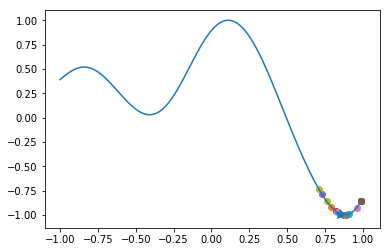

In [13]:
#training plot
y = out.cpu().detach().numpy()
k=0
plt.plot(xs,func[n-batch+k])
for i in range(20):
    plt.scatter(y[k][i+1][0],y[k][i+1][1])
plt.scatter(y[k][20][0],y[k][20][1],marker='*',s=100)
plt.show()
plt.close()

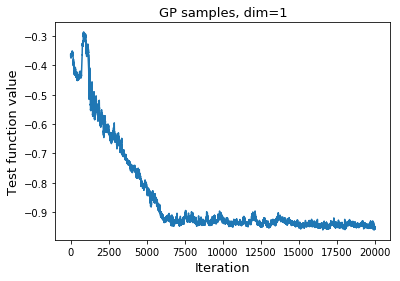

In [23]:
plt.plot(testing_loss)

plt.xlabel('Iteration',size=13)
plt.ylabel('Test function value',size=13)
plt.title('GP samples, dim=1',size=13)
#plt.legend()
#plt.savefig("trainingdatanum.pdf",bbox_inches="tight")
plt.show()
#print(testing_loss[-1])

In [21]:
#np.save('test_10000_100_50.npy',testing_loss)

In [17]:
#testing plot
f=44
func_t=np.array(func_t)
func_test = torch.from_numpy(func_t[f:f+1, :])
x0=torch.tensor([0.0]*func_test.size(0))
input_test,_,_=query(x0,func_test)
input_test=input_test.cuda()
with torch.no_grad():
            out_test,log_probs,test_rewards,entropies,test_actions = seq(input_test,func_test,future)
            min_step,_=min_loss(test_rewards)
            print('test loss:', min_step[-1].item())
            y = out_test.cpu().detach().numpy()

test loss: -0.9993818306745097


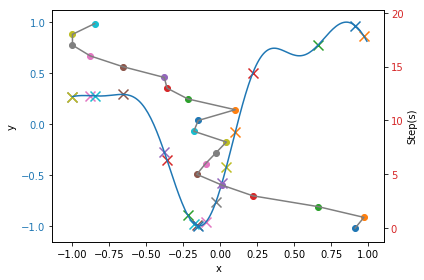

In [18]:
k = 0
x = torch.linspace(0, 1)

color = 'tab:blue'
fig,ax1= plt.subplots()
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax1.plot(xs,func_t[f])


ax1.tick_params(axis='y', labelcolor=color)
for i in range(step+future):
    ax1.scatter(y[k][i+1][0],y[k][i+1][1],marker='x',s=100)
#ax1.plot([1.0,1.0],[-2,2],'g--')

ax2 = ax1.twinx()

steps = np.arange(0, step+future, 1)
color = 'tab:red'
ax2.set_ylabel('Step(s)')  

ax2.plot(test_actions,steps, color='tab:grey')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks(np.arange(0, step+future+1, 5))
for i in range(step+future):
    ax2.scatter(test_actions[i],i)


fig.tight_layout() 

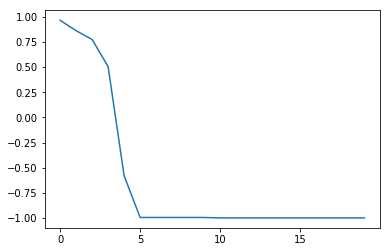

In [19]:
plt.plot(min_step)#,color='blue', linewidth=5.0, linestyle='--')
plt.xticks(np.arange(0, step+future, 5))
plt.show()